In [3]:
# Imports 


import sys
# setting path
sys.path.append('../core')
import os
#os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

from tqdm import tqdm
import copy
#import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

# import dfply
# from dfply import *
# import ray
# import datetime


import os
import warnings
warnings.filterwarnings("ignore")

#import torch
#torch.cuda.is_available()
#import tensorflow as tf
#print(tf.config.list_physical_devices('GPU'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy
import pickle

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')

2023-11-27 18:37:28.094208: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 18:37:28.114649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 18:37:28.430607: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Simplifications to Sepsis for Clustering: (1) Rewards no longer dependent on diabetes or no diabetes (averaged across them), (2) Initial state distribution now common across diabetes/no diabetes (averaged across them).

In [2]:
def idx_to_trunc(state_idx, hideGlucose=True, sa=False):
    """idx_to_trunc

    The state index is determined by using "bit" arithmetic, with the
    complication that not every state is binary

    :param state_idx: Given index (720)
    
    Returns a truncated state where the "action states", 
    antibiotics, vasopressors and ventilators, are omitted
    """
    term_base = 720/3 #starts with heart rate

    # Start with the given state index
    mod_idx = state_idx

    hr_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 3
    sysbp_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 2
    percoxyg_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 5
    glucose_state = np.floor(mod_idx/term_base).astype(int)
    
    categ_num = np.array([3,3,2,5])
    state_categs = [
            hr_state,
            sysbp_state,
            percoxyg_state,
            glucose_state]
    if hideGlucose:
        mod_idx %= term_base
        term_base /= 2
        antibiotic_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vaso_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vent_state = np.floor(mod_idx/term_base).astype(int)
        categ_num = np.array([3,3,2,2,2,2])
        state_categs = [
                hr_state,
                sysbp_state,
                percoxyg_state,
                antibiotic_state,
                vaso_state,
                vent_state]
    sum_idx = 0
    prev_base = 1
    for i in range(len(state_categs)):
        idx = len(state_categs) - 1 - i
        sum_idx += prev_base*state_categs[idx]
        prev_base *= categ_num[idx]
        
    if sa:
        mod_idx %= term_base
        term_base /= 2
        antibiotic_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vaso_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vent_state = np.floor(mod_idx/term_base).astype(int)
        action = 4*antibiotic_state + 2*vaso_state + 2*vent_state
        return sum_idx, action
    else:
        return sum_idx

idx_to_trunc(719, sa=True)

(143, 0)

In [3]:
diagnostic = False
#horizons = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
horizon = 60
#n_trajectories = [40,80,120,160,200,240,280,320,360,400,440,480]
#n_trajectories = list(np.arange(10,55,5))
n_trajectories = list(np.arange(100,1100,100))[-2:]
#n_trajectories = list(np.arange(10,210,10))

hideGlucose = True
import multiprocessing
trials=1

labelsTrials = []
softClustEMsTrials = []
clusterAccsTrials = []
clusterAccsNoProjsTrials = []
classAccsTrials = []
hardClustEMAccsTrials = []
softClustEMAccsTrials = []
hardEMAccsTrials = []
softEMAccsTrials = []
datasetsTrials = []
softEMsTrials = []


for trial in range(trials):
        
    clusterAccs = []
    clusterAccsNoProjs = []
    modelEstims = []
    classAccs = []
    hardClustEMs = []
    hardClustEMAccs = []
    softClustEMs = []
    softClustEMAccs = []
    hardEMs = []
    hardEMAccs = []
    softEMs = []
    softEMAccs = []
    labelsTrial = []
    
    start_seed = trial*multiprocessing.cpu_count()
    print("Trial", trial, "with start seed", start_seed)

    datasets_trajs = []
    datasets_truncs = []

    for n_samples in n_trajectories:
        print("Current Horizon is:", horizon)
        print("Current Trajectories is:", n_samples)

        #########SETUP#########

        # Get the transition and reward matrix from file
        with open("./data/diab_txr_mats-replication.pkl", "rb") as f:
            mdict = pickle.load(f)

        envs = []

        P = mdict["tx_mat"]
        x_dist = mdict["p_initial_state"].mean(0)
        u_dist = mdict["p_mixture"]
        gamma = 1


        #nStates = P.shape[2]
        nActions = P.shape[1]

        R = mdict["r_mat"].mean(0)

        pi_b = np.load('data/sepsisPol.npy')
        pi_e = pi_b.mean(0)

        term = -1
        mdp = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

        np.random.seed(start_seed)
        dataset = confound_mdp.collect_sample(n_samples, mdp, pi_b, horizon, iid=False)
        datasets_trajs.append(np.copy(dataset))

        for m in tqdm(range(dataset.shape[0])):
            for t in range(dataset.shape[1]):
                #s, a, u, s', r
                dataset[m,t,0] = idx_to_trunc(dataset[m,t,0], hideGlucose=hideGlucose)
                dataset[m,t,3] = idx_to_trunc(dataset[m,t,3], hideGlucose=hideGlucose)

        datasets_truncs.append(np.copy(dataset))


        nStates = int(720/8) if not hideGlucose else int(720/(5))

        stateactions = dataset[:, :, [0, 1]]
        memorder = 'C'

        if memorder == 'F':
            stateactions = (dataset[:,:,0] + dataset[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
        else:
            stateactions = (dataset[:,:,0]*nActions + dataset[:,:,1]).astype(int)
        states = (dataset[:,:,0]).astype(int)
        actions = (dataset[:,:,1]).astype(int)
        currstates = dataset[:,:,[0,1]].astype(int)
        confounders = dataset[:,:,2].astype(int)
        labels = confounders[:,0].astype(int)
        nextstates = dataset[:,:,3].astype(int)

        L = 2
        K = 2
        #S = nStates*nActions
        #N = len(threes)


        ########SUBSPACE ESTIMATION########

        sadim = nStates*nActions
        spdim = nStates
        omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
        omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
        onehotsa = np.eye(sadim)[stateactions]
        #onehotsaflat = copy.deepcopy(onehotsa)
        onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
        onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
        sz = int(onehotsa.shape[0]/3)

        eigvalsa, eigvecsa = getEig(onehotsa[:sz], onehotsp[:sz], omegaone, omegatwo, K, wt=True, smalldata=False, device='/CPU:0')


        #########CLUSTERING#########

        device = "/CPU:0"

        hs = np.array([geth(onehotsa[sz:,omegaone,:,:], 
                                         onehotsp[sz:,omegaone,:]), 
                                  geth(onehotsa[sz:,omegatwo,:,:], 
                                       onehotsp[sz:,omegatwo,:])], dtype=np.float32)

        statmns = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=True)

        statNoProjs = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=False)
        if diagnostic:
            hi = 0.00005 if hideGlucose else 0.00012
            clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                           lo=0, hi=hi, step=0.02*hi) #0,0.01, 0.0001
            plt.show()
            clusterDiagnostics(statNoProjs, K=K, labels=confounders[sz:, 0],
                       lo=0, hi=hi, step=0.02*hi) #0,0.01, 0.0001
            plt.show()


        thresh = 2e-5 if hideGlucose else 0.00003 #0.0005
        clusterlabs = sklearn.cluster.spectral_clustering((statmns < thresh).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')

        clusterlabsNoProjs = sklearn.cluster.spectral_clustering((statNoProjs < thresh).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')

        permutation = np.argmax([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])])
        if diagnostic:
            print(permutation, np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))
        clusterAccs.append(np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))

        clusterAccsNoProjs.append(np.max([np.mean(clusterlabsNoProjs == confounders[sz:, 0]), 
                        np.mean(clusterlabsNoProjs != confounders[sz:, 0])]))

        ########MODEL ESTIMATION#########
        Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                             states[sz:,:], 
                             actions[sz:,:], 
                             nextstates[sz:,:],
                            K=K, nStates=nStates, nActions=nActions, hard=True)
        modelEstims.append(Phat_ksa)


        ########CLASSIFICATION#########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)
        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        subspaceClass = classify(Phat_ksa, states[:sz,:], actions[:sz,:], 
                               nextstates[:sz,:], piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        if diagnostic:
            print('Subspace Classification accuracy:', [np.mean(labels[:sz] == subspaceClass), 
                                                    np.mean(labels[:sz] != subspaceClass)][permutation])
        classAccs.append([np.mean(labels[:sz] == subspaceClass), np.mean(labels[:sz] != subspaceClass)][permutation])


        ########EM ALGORITHM########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)

        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        maxapos = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        mleprobs = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                            prior=priorclass, startweights = startweights, labs=False)
        if diagnostic:
            print('MAP estimate overall accuracy:', [np.mean(labels == maxapos), np.mean(labels != maxapos)][permutation])

        # HARD EM
        expectclass, modelestimclass, loglikclass = em(maxapos, 
                                Phat_ksa, states, actions, 
                            nextstates, labels=labels, 
                            K=K, nStates=nStates, nActions=nActions,
                            prior = priorclass, reg = 1, max_iter=100,
                                                   permute=False, permutation=permutation,
                                                   checkin=1, hard=True, verbose=False)
        hardClustEMs.append([expectclass, modelestimclass, loglikclass])
        hardClustEMAccs.append(np.max([np.mean(labels == expectclass), np.mean(labels != expectclass)]))

        # SOFT EM
        normprobs = np.exp(mleprobs-np.max(mleprobs))
        regprobs = 0.8*(normprobs)/np.nansum(np.abs(normprobs), 0) + 0.1*np.ones(mleprobs.shape)
        expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                                    Phat_ksa, states, actions, 
                                nextstates, labels, 
                                K=2, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 1, permute=False,
                                permutation=permutation, checkin=1, hard=False, verbose=False)
        softClustEMs.append([expectclasssoft, modelestimclasssoft, loglikclasssoft])
        softClustEMAccs.append(np.max([np.mean(labels == expectclasssoft.argmax(0)),
                                np.mean(labels != expectclasssoft.argmax(0))]))
        print("Soft Clust EM Acc:", np.max([np.mean(labels == expectclasssoft.argmax(0)),
                                np.mean(labels != expectclasssoft.argmax(0))]))

        #############BASE EM###############

        labelsem = []
        logliksem = []
        for i in tqdm(range(30)):
            randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
            randmodel = getModelEstim(randlabs, states, actions, nextstates,
                                      K, nStates, nActions, hard=True)
            randlabs, randmodel, loglikrand = em(randlabs, randmodel,
               states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
            labelsem.append(randlabs)
            logliksem.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Hard EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem])
            plt.show()
        hardEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
        hardEMs.append([labelsem, logliksem])

        labelsemsoft = []
        logliksemsoft = []
        for i in tqdm(range(30)):
            unifs = np.random.uniform(size=len(dataset))
            randlabsoft = np.vstack([unifs, 1-unifs])
            randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                                      K, nStates, nActions, hard=False)
            randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
           states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
            labelsemsoft.append(randlabsoft)
            logliksemsoft.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
                        logliksemsoft)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            plt.ticklabel_format(style='plain',useOffset=False)
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Soft EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
            plt.show()
        softEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
        softEMs.append([labelsemsoft, logliksemsoft])
    
    
    clusterAccsTrials.append(clusterAccs)
    clusterAccsNoProjsTrials.append(clusterAccsNoProjs)
    classAccsTrials.append(classAccs)
    hardClustEMAccsTrials.append(hardClustEMAccs)
    softClustEMAccsTrials.append(softClustEMAccs)
    hardEMAccsTrials.append(hardEMAccs)
    softEMAccsTrials.append(softEMAccs)
    labelsTrial.append(clusterlabs)
    softClustEMsTrials.append(softClustEMs)
    datasetsTrials.append(datasets_trajs)
    softEMsTrials.append(softEMs)
        

100%|██████████| 144/144 [00:36<00:00,  3.90it/s]


Soft Clust EM Acc: 1.0


100%|██████████| 30/30 [00:03<00:00,  7.84it/s]


In [78]:
np.save('clusterAccs.npy', np.array(clusterAccsTrials))
np.save('clusterAccsNoProjs.npy', np.array(clusterAccsNoProjsTrials))
np.save('softEMAccs.npy', np.array(softEMAccsTrials))
np.save('softClustEMAccs.npy', np.array(softClustEMAccsTrials))

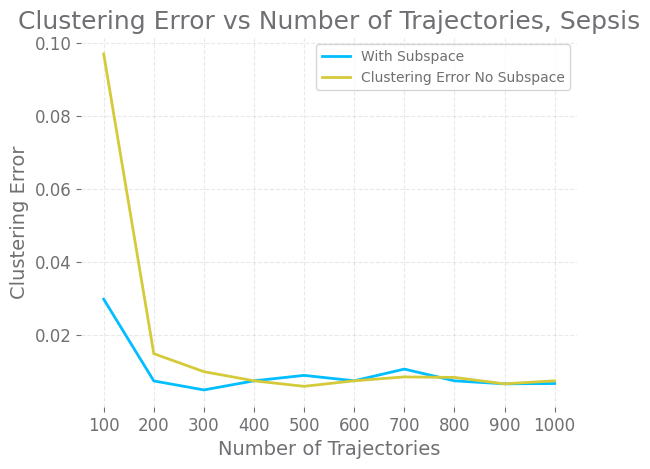

In [4]:
#plt.figure(figsize=(16,9))
plt.plot(1-np.median(np.array(clusterAccsTrials),0), label='With Subspace')
plt.plot(1-np.median(np.array(clusterAccsNoProjsTrials),0), label='Clustering Error No Subspace')
plt.ylabel("Clustering Error")
plt.xlabel("Number of Trajectories")
plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title("Clustering Error vs Number of Trajectories, Sepsis")
plt.legend()
#plt.savefig('figs/SepsisClustering.png')

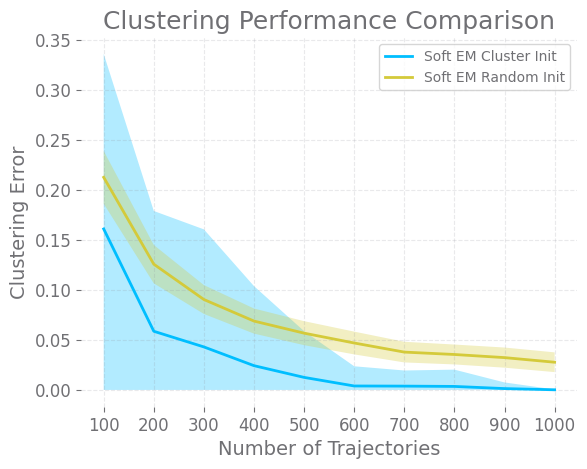

In [5]:
#plt.figure(figsize=(16,9))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''       
mean1 = 1-np.mean(np.array(softClustEMAccsTrials),0)
std1 = np.std(1-np.array(softClustEMAccsTrials),axis=0)
plt.plot(mean1,
         label='Soft EM Cluster Init')
plt.fill_between(np.arange(len(n_trajectories)), 
                 np.clip(mean1-std1,a_min=0,a_max=1),
                mean1+std1, alpha=0.3)
mean2 = 1-np.mean(np.array(softEMAccsTrials),0)
std2 = np.std(1-np.array(softEMAccsTrials),axis=0)
plt.plot(mean2,
        label='Soft EM Random Init')
plt.fill_between(np.arange(len(n_trajectories)), 
                 np.clip(mean2-std2,a_min=0,a_max=1),
                mean2+std2, alpha=0.3)

plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.ylabel("Clustering Error")
plt.xlabel("Number of Trajectories")
plt.title("Clustering Performance Comparison")
plt.legend()
plt.savefig('figs/SepsisEMCompMeanStd.png')

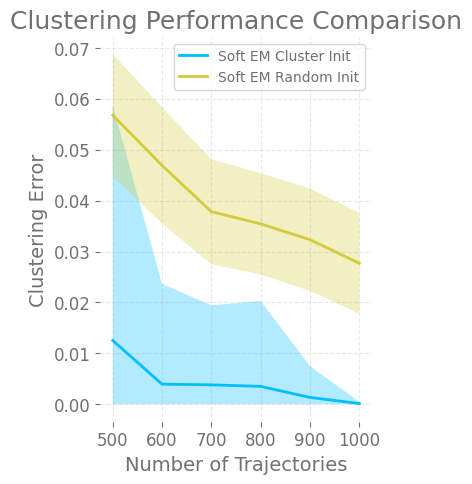

In [28]:
plt.figure(figsize=(3.5,5))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''       
mean1 = 1-np.mean(np.array(softClustEMAccsTrials),0)[4:]
std1 = np.std(1-np.array(softClustEMAccsTrials),axis=0)[4:]
plt.plot(mean1,
         label='Soft EM Cluster Init')
plt.fill_between(np.arange(len(n_trajectories[4:])), 
                 np.clip(mean1-std1,a_min=0,a_max=1),
                mean1+std1, alpha=0.3)
mean2 = 1-np.mean(np.array(softEMAccsTrials),0)[4:]
std2 = np.std(1-np.array(softEMAccsTrials),axis=0)[4:]
plt.plot(mean2,
        label='Soft EM Random Init')
plt.fill_between(np.arange(len(n_trajectories[4:])), 
                 np.clip(mean2-std2,a_min=0,a_max=1),
                mean2+std2, alpha=0.3)

plt.xticks(ticks = np.arange(len(n_trajectories[4:])),labels=n_trajectories[4:]) 
plt.ylabel("Clustering Error")
plt.xlabel("Number of Trajectories")
plt.title("Clustering Performance Comparison")
plt.legend()
plt.savefig('figs/SepsisEMCompMeanStd.png')

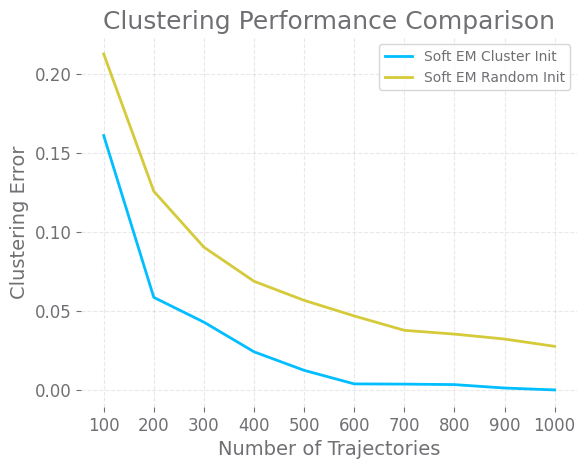

In [6]:
#plt.figure(figsize=(16,9))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''       
plt.plot(1-np.mean(np.array(softClustEMAccsTrials),0),
         label='Soft EM Cluster Init')
plt.plot(1-np.mean(np.array(softEMAccsTrials),0),
        label='Soft EM Random Init')

plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.ylabel("Clustering Error")
plt.xlabel("Number of Trajectories")
plt.title("Clustering Performance Comparison")
plt.legend()
plt.savefig('figs/SepsisEMCompMean.png')

## Off-Policy Evaluation

In [4]:
preds = [[clust[0].argmax(0) for clust in softClustEMs] for softClustEMs in softClustEMsTrials]

In [5]:
Rhat_sa = getR_sa(datasetsTrials[-1][-2], 720, nActions)
Rhat_asp = getR_asp(datasetsTrials[-1][-2], 720, nActions)

In [6]:
datasets = [[[datasetsTrial[i][(datasetsTrial[i][...,2] == k)[:,0]] 
              for k in range(K)] 
                 for i in range(len(datasetsTrial))]
                for datasetsTrial in datasetsTrials]
datasets_estim = [[[datasetsTrial[i][preds[t][i] == ((k + permutation)%2)] 
              for k in range(K)] 
                 for i in range(len(datasetsTrial))] 
                  for t,datasetsTrial in enumerate(datasetsTrials)] #n_trajs, u, dataset
#t, i, labels/loglik, 30 EM runs
datasets_estim_rand = [[[datasetsTrial[i][softEMsTrials[t][i][0][-1].argmax(0) == ((k + permutation)%2)] 
              for k in range(K)] 
                 for i in range(len(datasetsTrial))] 
                  for t,datasetsTrial in enumerate(datasetsTrials)]

In [10]:
import pickle
pickle.dump([preds, datasetsTrials, datasets_estim, datasets_estim_rand, softEMsTrials, permutation, pi_b, x_dist, u_dist, P, R],
            open( "misc/save.p", "wb" ))

In [ ]:
fqes_true = [[[confound_ope.fitted_q_evaluation(pi_e, datasets[t][i][k], horizon, mdp) for k in range(K)] 
             for i in range(len(n_trajectories))] for t in range(trials)]
fqes_estim = [[[confound_ope.fitted_q_evaluation(pi_e, datasets_estim[t][i][k], horizon, mdp) for k in range(K)]
             for i in range(len(n_trajectories))] for t in range(trials)]
fqes_estim_rand = [[[confound_ope.fitted_q_evaluation(pi_e, datasets_estim_rand[t][i][k], horizon, mdp) for k in range(K)]
             for i in range(len(n_trajectories))] for t in range(trials)]
fqes_estim_mean = [[confound_ope.fitted_q_evaluation(pi_e, datasetsTrials[t][i], horizon, mdp)
             for i in range(len(n_trajectories))] for t in range(trials)]

In [82]:
np.save('fqes_true.npy', np.array(fqes_true))
np.save('fqes_estim.npy', np.array(fqes_estim))
np.save('fqes_estim_ran.npy', np.array(fqes_estim_rand))
np.save('fqes_estim_mean.npy', np.array(fqes_estim_mean))

In [70]:
fqes_true = np.load('fqes_true.npy')
fqes_estim = np.load('fqes_estim.npy')
fqes_estim_rand = np.load('fqes_estim_ran.npy')
fqes_estim_mean = np.load('fqes_estim_mean.npy')
trials = 30
n_trajectories = list(np.arange(100,1100,100))

pi_b = np.load('data/sepsisPol.npy')
pi_e = pi_b.mean(0)

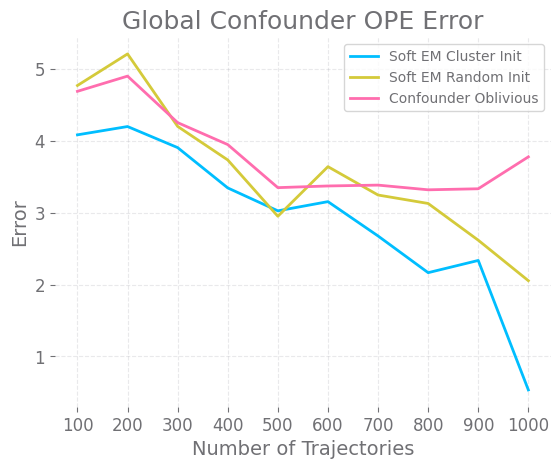

In [71]:
vals_true = np.array([[[(fqes_true[t][-1][k] * pi_e).sum(1) * u_dist[(k + permutation)%2] 
                          for k in range(K)] 
                            for i in range(len(n_trajectories))] 
                                for t in range(trials)]).sum(2)

vals_estim = np.array([[[(fqes_estim[t][i][k] * pi_e).sum(1) * u_dist[(k + permutation)%2] 
                          for k in range(K)] 
                            for i in range(len(n_trajectories))] 
                                for t in range(trials)]).sum(2)

vals_estim_rand = np.array([[[(fqes_estim_rand[t][i][k] * pi_e).sum(1) * u_dist[(k + permutation)%2] 
                          for k in range(K)] 
                            for i in range(len(n_trajectories))] 
                                for t in range(trials)]).sum(2)

vals_estim_mean = np.array([[(fqes_estim_mean[t][i] * pi_e).sum(1)
                            for i in range(len(n_trajectories))] 
                                for t in range(trials)])

plt.plot(np.max(np.abs(vals_true - vals_estim),2).mean(0), label='Soft EM Cluster Init')
plt.plot(np.max(np.abs(vals_true - vals_estim_rand),2).mean(0), label='Soft EM Random Init')
plt.plot(np.max(np.abs(vals_true - vals_estim_mean),2).mean(0), label='Confounder Oblivious')

plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title('Global Confounder OPE Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Error')
plt.legend()
plt.savefig('figs/globalOPElarge.png')

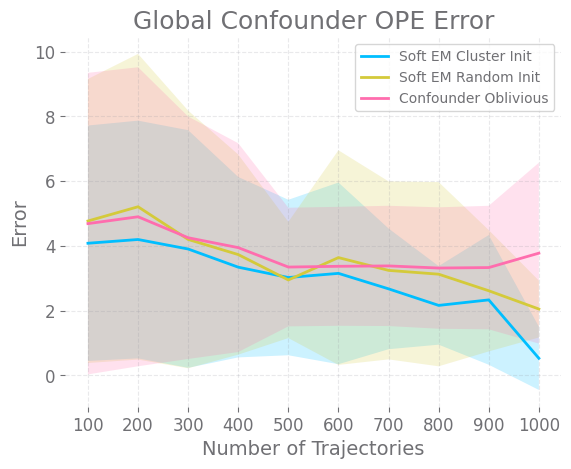

In [39]:
meanclust = np.max(np.abs(vals_true - vals_estim),2).mean(0)
stdclust = np.max(np.abs(vals_true - vals_estim),2).std(0)
plt.plot(meanclust, label='Soft EM Cluster Init')
plt.fill_between(np.arange(len(n_trajectories)), 
                        meanclust-stdclust,
                       meanclust+stdclust,
                       alpha=0.2)

meansoft = np.max(np.abs(vals_true - vals_estim_rand),2).mean(0)
stdsoft = np.max(np.abs(vals_true - vals_estim_rand),2).std(0)
plt.plot(meansoft, label='Soft EM Random Init')
plt.fill_between(np.arange(len(n_trajectories)), 
                        meansoft-stdsoft,
                       meansoft+stdsoft,
                       alpha=0.2)

meanobliv = np.max(np.abs(vals_true - vals_estim_mean),2).mean(0)
stdobliv = np.max(np.abs(vals_true - vals_estim_mean),2).std(0)
plt.plot(meanobliv, label='Confounder Oblivious')
plt.fill_between(np.arange(len(n_trajectories)), 
                        meanobliv-stdobliv,
                       meanobliv+stdobliv,
                       alpha=0.2)


plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title('Global Confounder OPE Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Error')
plt.legend()
plt.savefig('figs/globalOPElargeError.png')

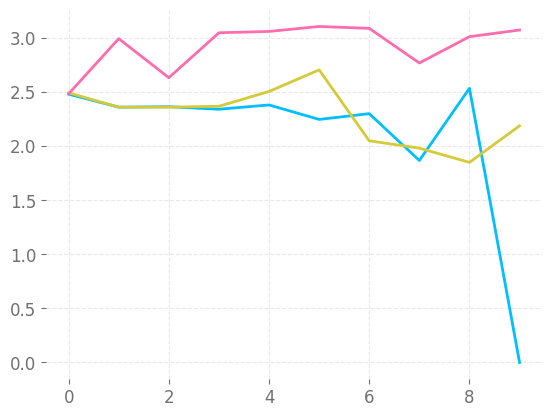

In [11]:
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim),2),0))
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim_rand),2),0))
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim_mean),2),0))

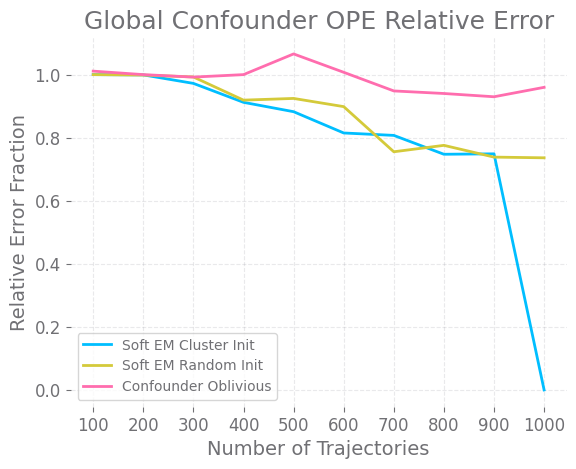

In [12]:
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim),2)/np.max(np.abs(vals_true),2),0), label='Soft EM Cluster Init')
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim_rand),2)/np.max(np.abs(vals_true),2), 0), label='Soft EM Random Init')
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim_mean),2)/np.max(np.abs(vals_true),2), 0), label='Confounder Oblivious')
plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title('Global Confounder OPE Relative Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Relative Error Fraction')
plt.legend()
plt.savefig('figs/globalOPERelLargeMedian.png')

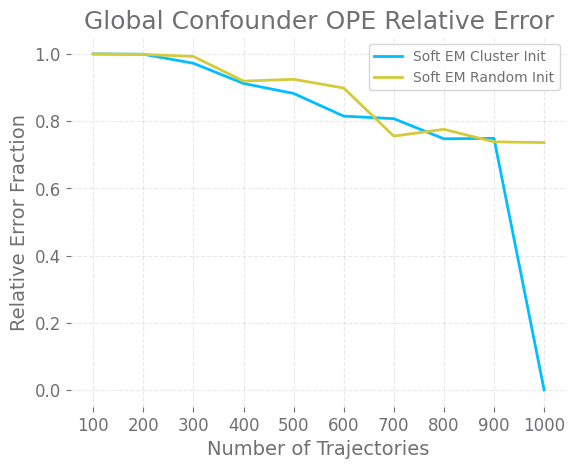

In [13]:
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim),2)/np.max(np.abs(vals_true),2),0), label='Soft EM Cluster Init')
plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim_rand),2)/np.max(np.abs(vals_true),2), 0), label='Soft EM Random Init')
#plt.plot(np.median(np.nanmax(np.abs(vals_true - vals_estim_mean),2)/np.max(np.abs(vals_true),2), 0), label='Confounder Unaware')
plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title('Global Confounder OPE Relative Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Relative Error Fraction')
plt.legend()
plt.savefig('figs/globalOPERelLargeMedianAware.png')

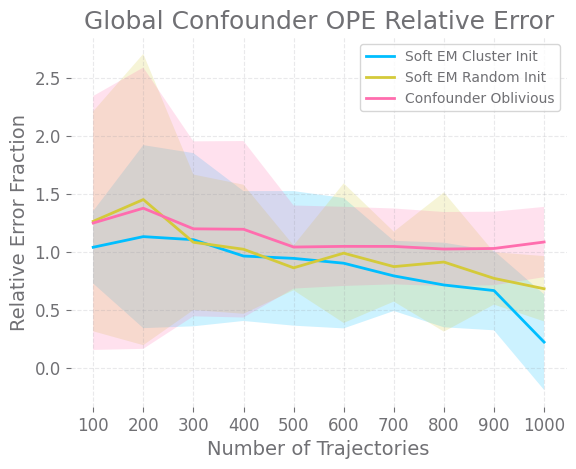

In [38]:
meanclust = (np.nanmax(np.abs(vals_true - vals_estim),2)/np.max(np.abs(vals_true),2)).mean(0)
stdclust = (np.nanmax(np.abs(vals_true - vals_estim),2)/np.max(np.abs(vals_true),2)).std(0)
plt.plot(meanclust, label='Soft EM Cluster Init')
plt.fill_between(np.arange(len(n_trajectories)), 
                        meanclust-stdclust,
                       meanclust+stdclust,
                       alpha=0.2)

meansoft = (np.nanmax(np.abs(vals_true - vals_estim_rand),2)/np.max(np.abs(vals_true),2)).mean(0)
stdsoft = (np.nanmax(np.abs(vals_true - vals_estim_rand),2)/np.max(np.abs(vals_true),2)).std(0)
plt.plot(meansoft, label='Soft EM Random Init')
plt.fill_between(np.arange(len(n_trajectories)), 
                        meansoft-stdsoft,
                       meansoft+stdsoft,
                       alpha=0.2)

meanobliv = (np.nanmax(np.abs(vals_true - vals_estim_mean),2)/np.max(np.abs(vals_true),2)).mean(0)
stdobliv = (np.nanmax(np.abs(vals_true - vals_estim_mean),2)/np.max(np.abs(vals_true),2)).std(0)
plt.plot(meanobliv, label='Confounder Oblivious')
plt.fill_between(np.arange(len(n_trajectories)), 
                        meanobliv-stdobliv,
                       meanobliv+stdobliv,
                       alpha=0.2)

plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title('Global Confounder OPE Relative Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Relative Error Fraction')
plt.legend()
plt.savefig('figs/globalOPERelLargeErrors.png')

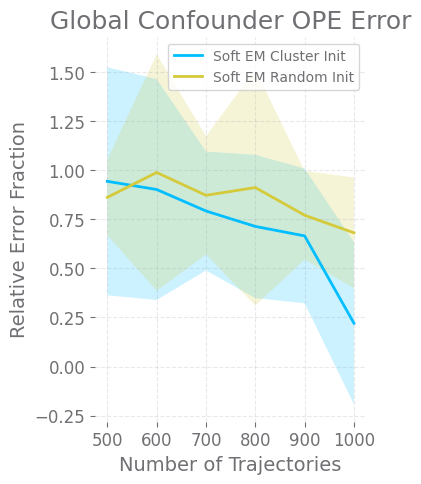

In [73]:
plt.figure(figsize=(3.5,5))
meanclust = (np.nanmax(np.abs(vals_true - vals_estim),2)/np.max(np.abs(vals_true),2)).mean(0)[4:]
stdclust = (np.nanmax(np.abs(vals_true - vals_estim),2)/np.max(np.abs(vals_true),2)).std(0)[4:]
plt.plot(meanclust, label='Soft EM Cluster Init')
plt.fill_between(np.arange(len(n_trajectories[4:])), 
                        meanclust-stdclust,
                       meanclust+stdclust,
                       alpha=0.2)

meansoft = (np.nanmax(np.abs(vals_true - vals_estim_rand),2)/np.max(np.abs(vals_true),2)).mean(0)[4:]
stdsoft = (np.nanmax(np.abs(vals_true - vals_estim_rand),2)/np.max(np.abs(vals_true),2)).std(0)[4:]
plt.plot(meansoft, label='Soft EM Random Init')
plt.fill_between(np.arange(len(n_trajectories[4:])), 
                        meansoft-stdsoft,
                       meansoft+stdsoft,
                       alpha=0.2)

'''
meanobliv = (np.nanmax(np.abs(vals_true - vals_estim_mean),2)/np.max(np.abs(vals_true),2)).mean(0)[4:]
stdobliv = (np.nanmax(np.abs(vals_true - vals_estim_mean),2)/np.max(np.abs(vals_true),2)).std(0)[4:]
plt.plot(meanobliv, label='Confounder Oblivious')
plt.fill_between(np.arange(len(n_trajectories[4:])), 
                        meanobliv-stdobliv,
                       meanobliv+stdobliv,
                       alpha=0.2)
'''

plt.xticks(ticks = np.arange(len(n_trajectories[4:])),labels=n_trajectories[4:]) 
plt.title('Global Confounder OPE Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Relative Error Fraction')
plt.legend()
plt.savefig('figs/globalOPERelLargeErrors.png')

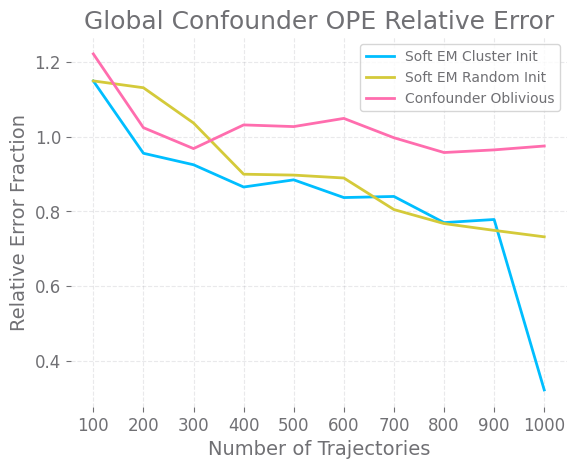

In [14]:
plt.plot((np.nanmax(np.abs(vals_true - vals_estim),2)/np.max(np.abs(vals_true),2)).mean(0), label='Soft EM Cluster Init')
plt.plot((np.nanmax(np.abs(vals_true - vals_estim_rand),2)/np.max(np.abs(vals_true),2)).mean(0), label='Soft EM Random Init')
plt.plot((np.nanmax(np.abs(vals_true - vals_estim_mean),2)/np.max(np.abs(vals_true),2)).mean(0), label='Confounder Oblivious')
plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title('Global Confounder OPE Relative Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Relative Error Fraction')
plt.legend()
plt.savefig('figs/globalOPERelLarge.png')

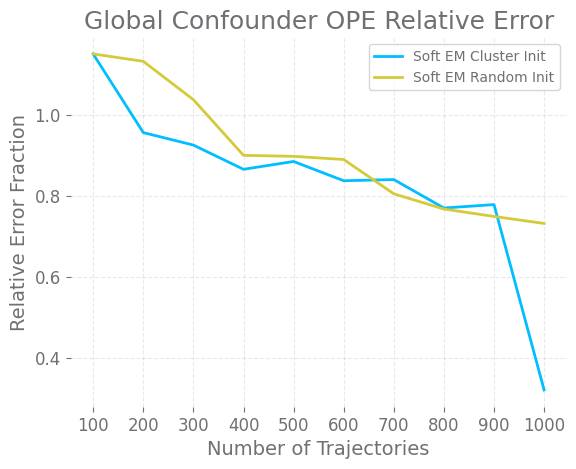

In [15]:
plt.plot((np.nanmax(np.abs(vals_true - vals_estim),2)/np.max(np.abs(vals_true),2)).mean(0), label='Soft EM Cluster Init')
plt.plot((np.nanmax(np.abs(vals_true - vals_estim_rand),2)/np.max(np.abs(vals_true),2)).mean(0), label='Soft EM Random Init')
#plt.plot((np.nanmax(np.abs(vals_true - vals_estim_mean),2)/np.max(np.abs(vals_true),2)).mean(0), label='Confounder Unaware')
plt.xticks(ticks = np.arange(len(n_trajectories)),labels=n_trajectories) 
plt.title('Global Confounder OPE Relative Error')
plt.xlabel('Number of Trajectories')
plt.ylabel('Relative Error Fraction')
plt.legend()
plt.savefig('figs/globalOPERelLargeAware.png')

## Optimization

In [1]:
#import pickle
#preds, datasetsTrials, datasets_estim, datasets_estim_rand, softEMsTrials, permutation, pi_b, x_dist, u_dist, P, R = pickle.load(open( "misc/save.p", "rb" ) )

In [4]:
rescale=True
rescaled_data = []
K=2
horizon=60
for k in range(K):
    rescaled_data_k = np.copy(datasets_estim[-1][-1][k])
    if rescale:
        rescaled_rewards = rescaled_data_k[:,:,4]
        rescaled_rewards = (rescaled_rewards - rescaled_rewards.mean()) / rescaled_rewards.std()
        rescaled_data_k[:,:,4] = rescaled_rewards
    rescaled_data.append(rescaled_data_k)
    
rescaled_data_rand = []
for k in range(K):
    rescaled_data_rand_k = np.copy(datasets_estim_rand[-1][-1][k])
    if rescale:
        rescaled_rewards = rescaled_data_rand_k[:,:,4]
        rescaled_rewards = (rescaled_rewards - rescaled_rewards.mean()) / rescaled_rewards.std()
        rescaled_data_rand_k[:,:,4] = rescaled_rewards
    rescaled_data_rand.append(rescaled_data_rand_k)
    

rescaled_data_mean = np.copy(np.vstack(datasets_estim_rand[-1][-1]))
if rescale:
    rescaled_rewards = rescaled_data_mean[:,:,4]
    rescaled_rewards = (rescaled_rewards - rescaled_rewards.mean()) / rescaled_rewards.std()
    rescaled_data_mean[:,:,4] = rescaled_rewards

In [5]:
V = np.zeros((horizon+1, 720))
def recursiveV(h, s, pi_e, R_sa, Pb_spsa, V):
    if h == horizon:
        return 0
    elif V[h,s] != 0:
        return V[h,s]
    else:
        Vhp = np.array([recursiveV(h+1,sp, pi_e, R_sa, Pb_spsa, V) for sp in range(720)])
        V[h+1,:] = Vhp
        return pi_e[s,:].T @ (R_sa[s,:] + Pb_spsa[:,s,:].T @ Vhp)
    
R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T 
P_spsa0 = P[0].transpose(2,1,0)
P_spsa1 = P[1].transpose(2,1,0)
V = np.zeros((horizon+1, 720))
#recursiveV(0, 0, pi_e, R_sa, P_spsa0)

def ope(policy):
    x_dist_nonzero = x_dist[x_dist>0]
    vals0 = np.array([recursiveV(0, int(s), policy, R_sa, P_spsa0, np.zeros((horizon+1, 720))) 
                      for s in tqdm(np.where(x_dist>0)[0])])
    vals1 = np.array([recursiveV(0, int(s), policy, R_sa, P_spsa1, np.zeros((horizon+1, 720))) 
                      for s in tqdm(np.where(x_dist>0)[0])])
    return u_dist[0]*np.dot(x_dist_nonzero, vals0) + u_dist[1]*np.dot(x_dist_nonzero, vals1)

#recursiveV(0, 0, pi_e, R_sa, P_spsa0, np.zeros((horizon+1, 720)))

#ope(pi_e)

In [6]:
mdp = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, 1)

In [7]:
datasets = [[[datasetsTrial[i][(datasetsTrial[i][...,2] == k)[:,0]] 
              for k in range(K)] 
                 for i in range(len(datasetsTrial))]
                for datasetsTrial in datasetsTrials]

In [ ]:
import jax
import jax.numpy as jnp

from IPython.display import display, clear_output
nActions=P.shape[1]

def random_choice_prob_index(a, axis=0):
    r = np.expand_dims(np.random.rand(a.shape[1-axis]), axis=axis)
    return (a.cumsum(axis=axis) > r).argmax(axis=axis)

FEATURE_DIM = 720
weights = jnp.array(np.random.normal(size=(nActions, FEATURE_DIM)))# @ jnp.array(jnp.eye(FEATURE_DIM)[200])
weights = jnp.array(pi_b.mean(0).T) #NOTE: this is shaped A x S.
weights_rand = jnp.array(pi_b.mean(0).T)


def get_loss(trajectory, weights, pi_b, FEATURE_DIM, pred_label, mean=False):
    states_traj = trajectory[:,0].astype(int)
    actions_traj = trajectory[:,1].astype(int)
    rewards_traj = trajectory[:,4]
    policy = jax.nn.softmax(weights, axis=0)
    probs = jnp.take(policy, states_traj, axis=1)
    if mean:
        is_weights = (probs[states_traj,actions_traj]
                      /(pi_b * u_dist[:,None,None]).sum(0)[states_traj,actions_traj])
    else:
        is_weights = probs[states_traj,actions_traj]/pi_b[pred_label][states_traj,actions_traj]
    #is_weights = jnp.clip(is_weights, np.sqrt(len(trajectory))) #truncated importance sampling
    loss = - jnp.nansum(
        jax.lax.stop_gradient(is_weights)
        * rewards_traj 
        * jnp.log(
            jnp.take(jnp.take(probs,actions_traj,axis=1),
                     jnp.arange(len(trajectory)),axis=0))
    )
    return loss

get_loss = jax.vmap(get_loss, (0,None,None,None,None,None), 0)

def loss_batch(dataset, weights, pi_b, FEATURE_DIM, pred_label, mean=False):
    losses = get_loss(dataset, weights, pi_b, FEATURE_DIM, pred_label, mean)
    return jnp.nanmean(losses.at[jnp.isinf(losses)].set(0))

loss_grad = jax.value_and_grad(loss_batch, argnums=1)


eta = 0.05
values = []
values_rand = []
fqe_evals = []
fqe_evals_rand = []
'''
fqe_evals.append(((np.array([(confound_ope.fitted_q_evaluation(pi_b.mean(0), datasets[-1][-1][k], horizon, mdp) * pi_b.mean(0)).sum(1) 
         for k in range(K)]) * u_dist[:,None]).sum(0)*x_dist).sum())
'''
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
#loss_batch(jnp.array(datasets_trajs[-1]), weights, jnp.array(pi_b), FEATURE_DIM)
for t in tqdm(range(10000)):
    loss = 0
    for k in range(K):
        pred_label = (k + permutation)%2
        loss_k, grad_k = loss_grad(jnp.array(rescaled_data[k]), weights, 
                                   jnp.array(pi_b), FEATURE_DIM, pred_label)
        loss += loss_k * u_dist[pred_label]
        weights -= eta * grad_k * u_dist[pred_label]
    weights = weights.at[jnp.isinf(weights)].set(0)
    weights = weights.at[jnp.isnan(weights)].set(0)
    values.append(loss)
    
    loss_rand = 0
    for k in range(K):
        pred_label = (k + permutation)%2
        loss_rand_k, grad_rand_k = loss_grad(jnp.array(rescaled_data_rand[k]), weights_rand, 
                                             jnp.array(pi_b), FEATURE_DIM, pred_label)
        loss_rand += loss_rand_k * u_dist[pred_label]
        weights_rand -= eta * grad_k * u_dist[pred_label]
    weights_rand = weights_rand.at[jnp.isinf(weights_rand)].set(0)
    weights_rand = weights_rand.at[jnp.isnan(weights_rand)].set(0)
    values_rand.append(loss_rand)
    
    
    if t % 1000 == 0:
        clear_output(wait = True)
        ax1.plot(values, label='Soft EM Cluster Init')
        ax1.plot(values_rand, label='Soft EM Random Init')
        ax1.legend()
        ax1.set_ylabel('Train Loss')
        policy = np.array(jax.nn.softmax(weights, 0).T)
        policy_rand = np.array(jax.nn.softmax(weights_rand, 0).T)
        
        fqe_eval = ((np.array([(confound_ope.fitted_q_evaluation(policy, 
                                    datasets[-1][-1][k], horizon, mdp) * policy).sum(1) 
                     for k in range(K)]) * u_dist[:,None]).mean(0) * x_dist).sum()
        fqe_eval_rand = ((np.array([(confound_ope.fitted_q_evaluation(policy_rand, 
                                    datasets[-1][-1][k], horizon, mdp) * policy_rand).sum(1) 
                     for k in range(K)]) * u_dist[:,None]).mean(0) * x_dist).sum()
        '''
        fqe_eval = ope(policy)
        fqe_eval_rand = ope(policy_rand)
        '''
        #fqe_eval = -(np.array([loss_batch(jnp.array(datasets[-1][-1][k]), weights, jnp.array(pi_b), FEATURE_DIM, 0) 
        # for k in range(K)]) * u_dist[:,None]).mean(0).sum()
        fqe_evals.append(fqe_eval)
        fqe_evals_rand.append(fqe_eval_rand)
        ax2.plot(fqe_evals, label='Soft EM Cluster Init')
        ax2.plot(fqe_evals_rand, label='Soft EM Random Init')
        ax2.legend()
        ax2.set_ylabel('Eval Value')
        display(fig)
    

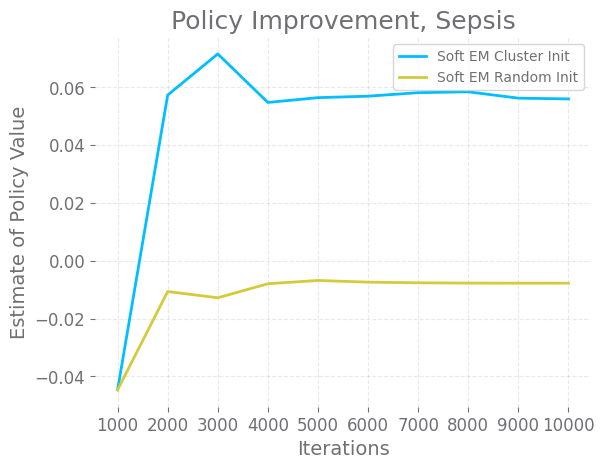

In [11]:
plt.plot(fqe_evals, label='Soft EM Cluster Init')
plt.plot(fqe_evals_rand, label='Soft EM Random Init')
plt.xticks(ticks = np.arange(len(fqe_evals)),labels=1000*(1+np.arange(len(fqe_evals)))) 
plt.ylabel('Estimate of Policy Value')
plt.xlabel('Iterations')
plt.title('Policy Improvement, Sepsis')
plt.legend()
plt.savefig('figs/globalPolicyImprovementHighLR.png')